In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from os import chdir 
chdir('C:\\Users\\afeki\\Desktop\\Code\\BootStrapDesicionTree\\')

In [2]:
from gradient_boosting_trees.gradient_boosting_regressor import CartGradientBoostingRegressor, \
    CartGradientBoostingRegressorKfold
from gradient_boosting_trees.gradient_boosting_abstract import GradientBoostingMachine
from Tree.node import Leaf


from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier

# Config

In [3]:
A1 = 2
A2 = 5
SIGMNA = 3
N_ROWS = 10**3
VAL_RATIO = 0.15
CATEGORICAL_DISTRIBUTION = 'uniform'
CATEGORY_SIZE = 100
CATEGORY_COLUMN_NAME = 'category'
Y_COL_NAME = 'y'
LEFT_GROUP = [i for i in range(CATEGORY_SIZE//2)]
SEED = 5
np.random.seed(SEED)

In [4]:
MAX_DEPTH = 3
N_ESTIMATORS = 100
LEARNING_RATE = 0.1

In [5]:
mse_val = {}

# Create simulated data
$$ y = a_1 \cdot x_1 + a_2 \cdot I(x_2 \in LEFT\_GROUP) + \sigma $$

$$ x1 - N(0,1) $$

In [6]:
def create_x_y(category_size):
    X = pd.DataFrame()
    X[CATEGORY_COLUMN_NAME] = np.random.randint(0, CATEGORY_SIZE, N_ROWS)
    X['x1'] = np.random.randn(N_ROWS)
    X[CATEGORY_COLUMN_NAME] = X[CATEGORY_COLUMN_NAME].astype('category')
    sigma = SIGMNA*np.random.randn(N_ROWS)
    y = A1*X['x1'] + A2*X[CATEGORY_COLUMN_NAME].isin(LEFT_GROUP) + sigma
    return X,y

In [7]:
from xgboost.core import Booster
def compute_ntrees_nleaves(gbm):
    total_number_of_trees = 0
    total_number_of_leaves = 0
    if isinstance(gbm,GradientBoostingMachine):
        for tree in gbm.trees:
            if not isinstance(tree.root, Leaf):
                total_number_of_trees += 1
                total_number_of_leaves += tree.n_leaves
    elif isinstance(gbm,GradientBoostingClassifier) or isinstance(gbm,GradientBoostingRegressor):
        total_number_of_trees = gbm.n_estimators_
        for tree in gbm.estimators_:
            total_number_of_leaves += tree[0].get_n_leaves()
    elif isinstance(gbm, Booster):
        df = gbm.trees_to_dataframe()
        total_number_of_leaves = df[df['Feature'] == 'Leaf'].shape[0]
        total_number_of_trees = df[df['Feature'] == 'Leaf']['Tree'].max()

    print(F'number of trees is {total_number_of_trees}')
    print(F'number of leaves is {total_number_of_leaves}')

In [8]:
import pandas as pd
from pandas.api.types import CategoricalDtype
from sklearn.base import BaseEstimator, TransformerMixin


# Pandas one hot encoder
class OneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.unique_values_for_col = {}

    def fit(self, X, y=None):
        for col in X.columns:
            self.unique_values_for_col[col] = X[col].unique().tolist()

    def transform(self, X):
        dataframes = []
        for col in X.columns:
            type = CategoricalDtype(categories=self.unique_values_for_col[col])
            dataframes.append(pd.get_dummies(pd.Series(X[col], dtype=type), prefix=col))
        return pd.concat(dataframes, axis=1)

# OUR IMPLEMENTATION
## KFOLD

In [9]:
from sklearn.model_selection import train_test_split
X,y = create_x_y(CATEGORY_SIZE)
X, X_val, y, y_val = train_test_split(X, y, test_size=VAL_RATIO, random_state=42)
kfold_df = X.copy()
kfold_df[Y_COL_NAME] = y
kfold_gbm = CartGradientBoostingRegressorKfold(Y_COL_NAME, max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS, learning_rate=LEARNING_RATE)
kfold_gbm.fit(kfold_df)
fi = pd.Series(kfold_gbm.compute_feature_importance()).sort_index()
fi/= fi.sum()
fi

category    0.68017
x1          0.31983
dtype: float64

C:\Users\afeki\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


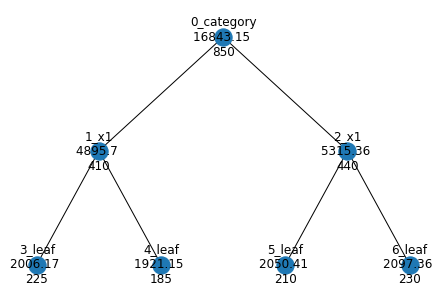

In [10]:
from Tree.tree_visualizer import TreeVisualizer
tree_vis = TreeVisualizer()
tree_vis.plot(kfold_gbm.trees[0].root)

In [11]:
compute_ntrees_nleaves(kfold_gbm)

number of trees is 14
number of leaves is 51


In [12]:
mse_val['Ours_KFOLD'] = np.mean(np.square(y_val -kfold_gbm.predict(X_val)))

## Vanilla gradient boosting regressor

In [13]:
vanilla_gbm = CartGradientBoostingRegressor(Y_COL_NAME, max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS, learning_rate=LEARNING_RATE)
vanilla_gbm.fit(kfold_df)
fi = pd.Series(vanilla_gbm.compute_feature_importance()).sort_index()
fi/= fi.sum()
fi

category    0.728459
x1          0.271541
dtype: float64

In [14]:
compute_ntrees_nleaves(vanilla_gbm)

number of trees is 100
number of leaves is 400


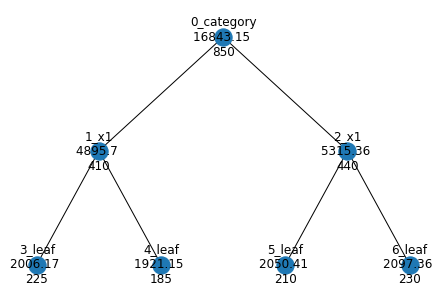

In [15]:
tree_vis = TreeVisualizer()
tree_vis.plot(vanilla_gbm.trees[0].root)

In [16]:
mse_val['Ours_Vanilla'] = np.mean(np.square(y_val -vanilla_gbm.predict(X_val)))

## Ours Mean Imputing

In [17]:
category_to_mean = kfold_df[[CATEGORY_COLUMN_NAME,'y']].groupby(CATEGORY_COLUMN_NAME)['y'].mean().to_dict()
ours_mean_df = kfold_df.copy()
ours_mean_df[CATEGORY_COLUMN_NAME] = ours_mean_df[CATEGORY_COLUMN_NAME].map(category_to_mean)
ours_mean_df[CATEGORY_COLUMN_NAME] = ours_mean_df[CATEGORY_COLUMN_NAME].astype('float')
ours_mean_gbm = CartGradientBoostingRegressor(Y_COL_NAME, max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS, learning_rate=LEARNING_RATE)
ours_mean_gbm.fit(ours_mean_df)
fi = pd.Series(ours_mean_gbm.compute_feature_importance()).sort_index()
fi/= fi.sum()
fi

category    0.686301
x1          0.313699
dtype: float64

In [18]:
X_val_mean_imputed = X_val.copy()
X_val_mean_imputed[CATEGORY_COLUMN_NAME] = X_val_mean_imputed[CATEGORY_COLUMN_NAME].map(category_to_mean)
X_val_mean_imputed[CATEGORY_COLUMN_NAME].astype('float')
mse_val['Ours_MeanImputing'] = np.mean(np.square(y_val -ours_mean_gbm.predict(X_val_mean_imputed)))

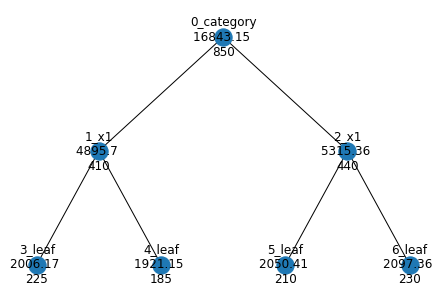

In [19]:
tree_vis = TreeVisualizer()
tree_vis.plot(ours_mean_gbm.trees[0].root)

In [20]:
compute_ntrees_nleaves(ours_mean_gbm)

number of trees is 100
number of leaves is 394


## Ours mean imputing with kfold

In [21]:
ours_mean_gbm = CartGradientBoostingRegressorKfold(Y_COL_NAME, max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS, learning_rate=LEARNING_RATE)
ours_mean_gbm.fit(ours_mean_df)
fi = pd.Series(ours_mean_gbm.compute_feature_importance()).sort_index()
fi/= fi.sum()
mse_val['Ours_MeanImputingKfold'] = np.mean(np.square(y_val -ours_mean_gbm.predict(X_val_mean_imputed)))
fi

category    0.725463
x1          0.274537
dtype: float64

In [22]:
compute_ntrees_nleaves(ours_mean_gbm)

number of trees is 18
number of leaves is 66


## SKLEARN - One Hot

In [23]:
one_hot = OneHotEncoder()
one_hot.fit(X['category'].to_frame())
x_one_hot = one_hot.transform(X['category'].to_frame())
x_one_hot['x1'] = X['x1']
x_one_hot_val = one_hot.transform(X_val['category'].to_frame())
x_one_hot_val['x1'] = X_val['x1']

clf = GradientBoostingRegressor(n_estimators=  N_ESTIMATORS, max_depth = MAX_DEPTH - 1,learning_rate = LEARNING_RATE)
clf.fit(x_one_hot, y)
fi = pd.Series(clf.feature_importances_, index = x_one_hot_val.columns)
print(F"x1 feature importance is: {np.round(fi['x1'],3)}")
compute_ntrees_nleaves(clf)

x1 feature importance is: 0.569
number of trees is 100
number of leaves is 400


In [24]:
mse_val['Sklearn_OneHot'] = np.mean(np.square(y_val -clf.predict(x_one_hot_val)))

## SKLEARN - Mean Imputing

In [25]:
X_m = X.copy()
X_m[CATEGORY_COLUMN_NAME] = X_m[CATEGORY_COLUMN_NAME].map(category_to_mean)
X_m[CATEGORY_COLUMN_NAME] = X_m[CATEGORY_COLUMN_NAME].astype('float')
clf = GradientBoostingRegressor(n_estimators=  N_ESTIMATORS, max_depth = MAX_DEPTH - 1,learning_rate = LEARNING_RATE)
clf.fit(X_m, y)
fi =pd.Series(clf.feature_importances_, index = X_m.columns)
print(F"x1 feature importance is: {np.round(fi['x1'],3)}")
compute_ntrees_nleaves(clf)

x1 feature importance is: 0.315
number of trees is 100
number of leaves is 399


In [27]:
mse_val['Sklearn_MeanImputing'] = np.mean(np.square(y_val -clf.predict(X_val_mean_imputed)))

## XGBOOST - One Hot

In [28]:
import xgboost as xgb

In [29]:
dtrain = xgb.DMatrix(x_one_hot, label=y)
param = {'max_depth': MAX_DEPTH - 1, 'eta': LEARNING_RATE, 'objective': 'reg:linear'}
num_round = N_ESTIMATORS
bst = xgb.train(param, dtrain, num_round)

[10:58:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


In [30]:
fi = pd.Series(bst.get_score(importance_type='gain'))
fi /= fi.sum()
print(F"x1 feature importance is: {np.round(fi['x1'],3)}")
compute_ntrees_nleaves(bst)

x1 feature importance is: 0.046
number of trees is 99
number of leaves is 384


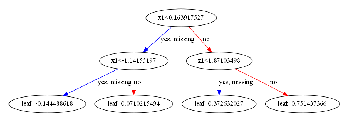

In [31]:
xgb.plot_tree(bst,num_trees= 0)
plt.rcParams['figure.figsize'] = [5, 20]
plt.show()

In [32]:
dval = xgb.DMatrix(x_one_hot_val)
mse_val['XGBOOST_OneHot'] = np.mean(np.square(y_val -bst.predict(dval)))

## XGBOOST - Mean Imputing

In [33]:
X_m[CATEGORY_COLUMN_NAME] = X_m[CATEGORY_COLUMN_NAME].astype('float')
dtrain = xgb.DMatrix(X_m, label=y)
param = {'max_depth': MAX_DEPTH - 1, 'eta': LEARNING_RATE, 'objective': 'reg:linear'}
num_round = N_ESTIMATORS
bst = xgb.train(param, dtrain, num_round)

[10:58:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


In [34]:
fi = pd.Series(bst.get_score(importance_type='gain'))
fi /= fi.sum()
print(F"x1 feature importance is: {np.round(fi['x1'],3)}")
compute_ntrees_nleaves(bst)

x1 feature importance is: 0.176
number of trees is 99
number of leaves is 394


In [35]:
X_val_mean_imputed[CATEGORY_COLUMN_NAME] = X_val_mean_imputed[CATEGORY_COLUMN_NAME].astype('float')
dval = xgb.DMatrix(X_val_mean_imputed.fillna(0))
mse_val['XGBOOST_MeanImputing'] = np.mean(np.square(y_val -bst.predict(dval)))

## Catboost

In [36]:
# !pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [37]:
from catboost import Pool, CatBoostRegressor
# initialize data
# initialize Pool
train_pool = Pool(X, 
                  y, 
                  cat_features=[0])

# specify the training parameters 
model = CatBoostRegressor(iterations=100, 
                          depth=3, 
                          learning_rate=0.1, 
                          loss_function='RMSE',logging_level = 'Silent')
#train the model
model.fit(train_pool)

In [38]:
print(model.feature_names_)
model.feature_importances_

['category', 'x1']


array([42.04581998, 57.95418002])

In [39]:
val_pool = Pool(X_val, 
                  cat_features=[0])

In [40]:
mse_val['CATBOOST_Vanilla'] = np.mean(np.square(y_val -model.predict(val_pool)))

In [41]:
pd.Series(mse_val).sort_values()

XGBOOST_MeanImputing      10.744936
Sklearn_MeanImputing      10.801449
Ours_MeanImputing         10.836091
Ours_Vanilla              11.282514
CATBOOST_Vanilla          11.941784
Ours_MeanImputingKfold    12.037648
Ours_KFOLD                12.784114
Sklearn_OneHot            14.995153
XGBOOST_OneHot            15.068652
dtype: float64

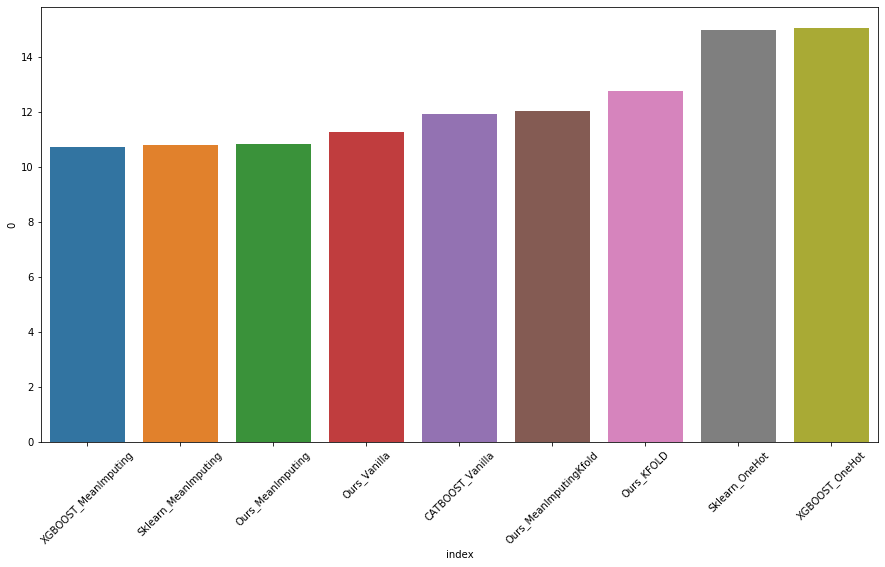

In [42]:
import seaborn as sns
plt.figure(figsize=(15,8))
chart = sns.barplot(x="index", y= 0, data=pd.Series(mse_val).sort_values().to_frame().reset_index())
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()